# KNN Properties

Imports and Helper Functions
---

This section includes imports and code for helper functions used to visualize classifier output. You are not responsible for understanding how the plotting and visualization code works.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from sklearn import neighbors, datasets, tree
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import DistanceMetric

from io import StringIO  
from subprocess import call
import os

In [3]:
%matplotlib inline

def plot_unit_circle(metric):
    """Plot the unit circle (set of points at distance 1 from the origin)
    using the specified metric. The metric can be any string accepted by
    the DistanceMetric.get_metric function.
    """
    
    #Create a dense grid of points slightly larger than the unit square
    xx, yy = np.meshgrid(np.arange(-1.1, 1.1,0.01), np.arange(-1.1,1.1,0.01))
    xl = xx.flatten()
    yl = yy.flatten()
    xy = np.vstack((xl,yl)).T

    #Compute distances to the origin
    dist = DistanceMetric.get_metric(metric)
    dl = dist.pairwise(xy,[[0,0]])
    dg = dl.reshape(xx.shape)    

    #Plot a contour where the value of the distance function is 1
    CS=plt.contour(xx,yy,dg, levels=[1] );
    plt.clabel(CS, inline=1, fontsize=10)
    plt.axis("square")
    plt.grid(True)
    plt.ylim((-1.5,1.5));
    plt.xlim((-1.5,1.5));
    plt.plot([0],[0],'ok');
    plt.title("Unit Circle: "+metric + " distance")
    
def plot2d_data(x,y,data_name,class_names,feature_names,markers=['sr','^b','og']):
    """Plot a 2d data set. x must be an Nx2 array of feature values. 
    y must be a N-long array of label values. data_name is a 
    string giving the name of the data set. The class labels
    must be intergers between 1 and C. class_names must be a 
    list of strings naming the classes. feature_names must be a
    list of strings naming the features."""

    for i in 1+np.arange(len(class_names)):
          plt.plot(x[y==i,0],x[y==i,1],markers[i-1], alpha=0.5);
    plt.xlabel(feature_names[0]);
    plt.ylabel(feature_names[1]);
    plt.grid(True)
    plt.title(data_name)
    plt.legend(class_names)
    plt.tight_layout()

def plot2d_class_map(clf,x,y,data_name,class_names,feature_names,show_data=True,markers=['sr','^b','og']):   

    if(show_data):
        plot2d_data(x,y,data_name,class_names,feature_names,markers=markers)

    #Prepare grid for plotting decision surface
    gx1, gx2 = np.meshgrid(np.arange(1.05*min(x[:,0]), 1.05*max(x[:,0]),(max(x[:,0])-min(x[:,0]))/200.0 ),
                             np.arange(1.05*min(x[:,1]), 1.05*max(x[:,1]),(max(x[:,1])-min(x[:,1]))/200.0))
    gx1l = gx1.flatten()
    gx2l = gx2.flatten()
    gx   = np.vstack((gx1l,gx2l)).T

    #Compute a prediction for every point in the grid
    gyhat = clf.predict(gx)
    gyhat = gyhat.reshape(gx1.shape)

    #Plot the results
    colors = ['#FFAAAA', '#AAAAFF','#AAFFAA']
    cmap_light = ListedColormap(colors[:int(max(y))])
    plt.pcolormesh(gx1,gx2,gyhat,cmap=cmap_light)
    
    plt.xlabel(feature_names[0]);
    plt.ylabel(feature_names[1]);
    plt.grid(True)
    plt.title(data_name)
    plt.legend(class_names)    
    plt.axis('tight');

def get_random_classification_function():
    #Get a random set of labeled points
    xtrue,ytrue = datasets.make_classification(n_samples=50, n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=2, class_sep=0.1);
    xtrue = xtrue - np.min(xtrue,axis=0);
    xtrue = xtrue / np.max(xtrue,axis=0);
    ytrue = ytrue+1

    #Fit a KNN classifier to the points
    clf_true = neighbors.KNeighborsClassifier(1, weights='uniform',metric='euclidean')
    clf_true.fit(xtrue, ytrue)
    
    return (clf_true,xtrue,ytrue)

def get_random_labeled_data(clf,N):
    #Sample and label a data set
    xsamp = np.random.rand(N,2)
    ysamp = clf.predict(xsamp)
    return (xsamp,ysamp)


## Geometry, Distance, and Similarity

Many machine learning algorithms rely on distance or similarity functions. Some distance functions to explore for KNN include the $\ell_p$ norm-based distances shown below. See the documentation for sklearn.neighbors.DistanceMetric for a list of additional distance metrics you can use with KNN.

  * Euclidean Distance ($\ell_2$ norm): $||x-y||_2 = \sqrt{\sum_{d=1}^D (x_d-y_d)^2}$
  
  * Manhattan Distance ($\ell_1$ norm): $||x-y||_1 = \sum_{d=1}^D |x_d-y_d|$
  
  * Chebyshev Distance ($\ell_{\infty}$ norm): $||x-y||_{\infty} = \max_d |x_d-y_d|$
  
Below, we visualize each of these metrics by showing a plot of their unit circle (the set of points at distance 1 from the origin according to the metric.

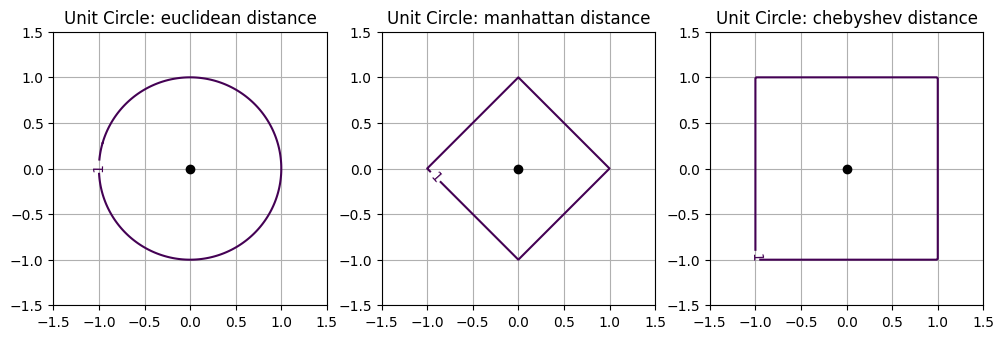

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plot_unit_circle("euclidean")
plt.subplot(1,3,2); plot_unit_circle("manhattan")
plt.subplot(1,3,3); plot_unit_circle("chebyshev")

## KNN Classification

In this section, we illustrate some properties of the KNN classifier. We first load a data set, select two feature dimensions to use, and then apply a standard scaling transformation. We then visualize the data as a scatter plot with one axis per feature. The points are colored according to class.

### Convergence of KNN in the Infinite Data Limit

Every classifier makes a trade-off between two sources of error: bias and variance. You can think of bias as the classifier's expected error (with the expectation taken over data sets of a fixed size N all generated from the same distribution). You can think of variance as the expected variability in the classifier's output (again, with the expectation taken over data sets of a fixed size N all generated from the same distribution). 

If the underlying distribution of class labels is noise-free (e.g., if when you see two instances with the same x, they always have the same y), then in the limit of infinite data, KNN with K=1 has 0 bias. In other words, the decision surface learned by KNN converges to the "true" decision surface. However, KNN with K=1 has high variability when N is small. For example, when N is small, the decision surface map induced by different training data sets of size N can be very different from each other.

To illustrate these points, we first construct a random true decision surface with no label noise below. We will use it to explore the bias and variance of 1NN.

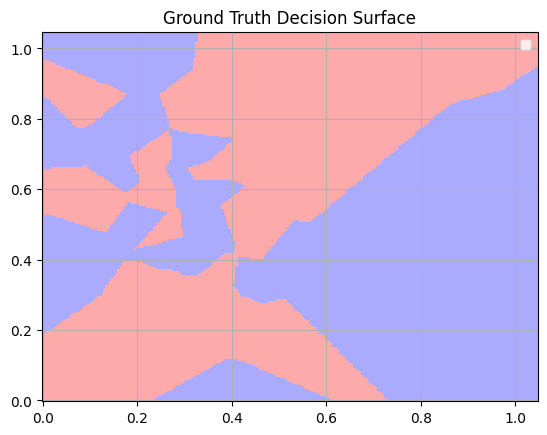

In [5]:
#Generate a random ground truth classification function
#and plot its decision surface.

clf_true,xtrue,ytrue = get_random_classification_function()
plot2d_class_map(clf_true,xtrue,ytrue,"Ground Truth Decision Surface",["Class 0","Class 1"],["",""],show_data=False)
plt.show()

Next, we sample training sets of increasing sizes from this true model, and use them to fit KNN with K=1. We can see that as N increases, the learned model converges to the ground truth decision surface, indicating that the bias goes to 0.

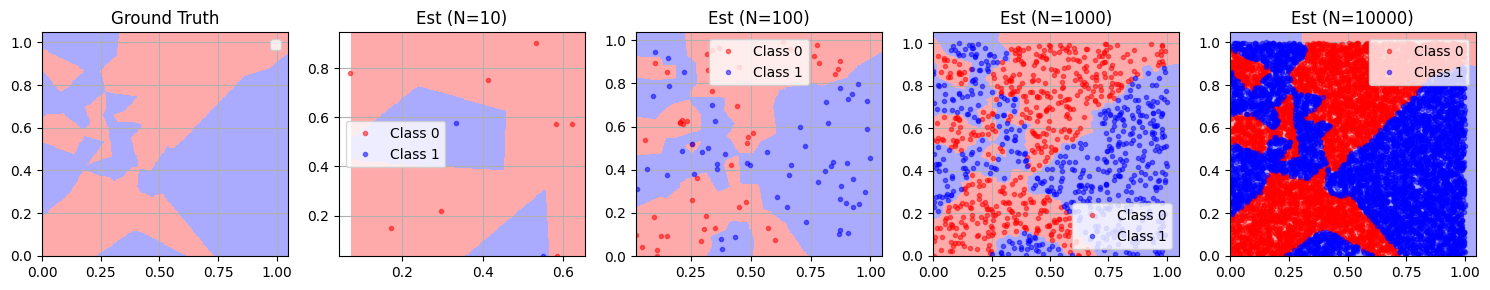

In [6]:

#Set numbers of training points
N=[10,100,1000,10000]

#Create a figure
plt.figure(1,figsize=(3*(1+len(N)),3))

#Plot ground truth decision surface
plt.subplot(1,1+len(N),1)
plot2d_class_map(clf_true,xtrue,ytrue,"Ground Truth",["Class 0","Class 1"],["",""],show_data=False)

for n in range(len(N)):
    #Get a sample of data points labeled by the true classifer
    #and create a 1NN classifier from it.
    xsamp, ysamp =get_random_labeled_data(clf_true,N[n])
    clf_est = neighbors.KNeighborsClassifier(1, weights='uniform',metric='euclidean')
    clf_est.fit(xsamp, ysamp)
    #Plot the estimated classifier's decision surface
    plt.subplot(1,1+len(N),2+n)
    plot2d_class_map(clf_est,xsamp,ysamp,"Est (N=%d)"%(N[n]),["Class 0","Class 1"],["",""],markers=['r.','b.'])
plt.show()    


Next, we sample multiple training sets all of size 10 from this true model, and use them to fit KNN with K=1. We can see that the learned classifiers are highly variable, as shown through their decision surface maps. This demonstrates the high variability of KNN with K=1 when N is small.

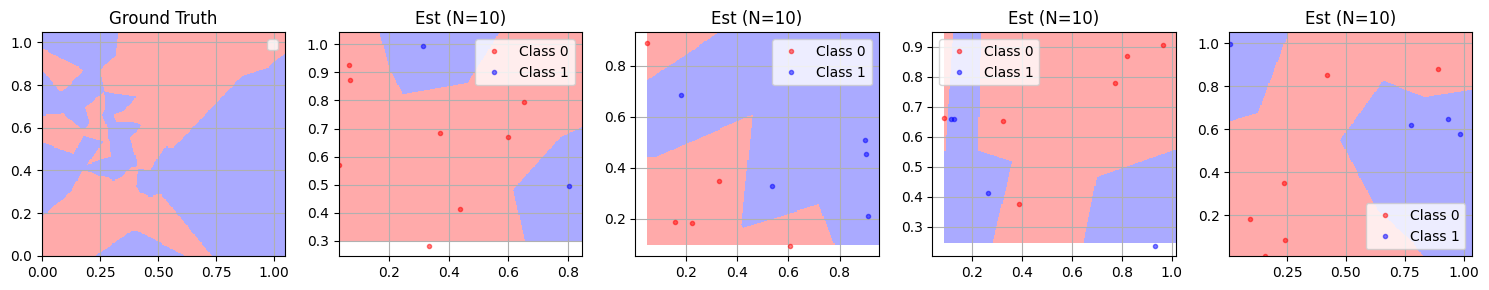

In [7]:

#Set numbers of training points
N=[10,10,10,10]

#Create a figure
plt.figure(1,figsize=(3*(1+len(N)),3))

#Plot ground truth decision surface
plt.subplot(1,1+len(N),1)
plot2d_class_map(clf_true,xtrue,ytrue,"Ground Truth",["Class 0","Class 1"],["",""],show_data=False)

for n in range(len(N)):
    #Get a sample of data points labeled by the true classifer
    #and create a 1NN classifier from it.
    xsamp, ysamp =get_random_labeled_data(clf_true,N[n])
    clf_est = neighbors.KNeighborsClassifier(1, weights='uniform',metric='euclidean')
    clf_est.fit(xsamp, ysamp)
    #Plot the estimated classifier's decision surface
    plt.subplot(1,1+len(N),2+n)
    plot2d_class_map(clf_est,xsamp,ysamp,"Est (N=%d)"%(N[n]),["Class 0","Class 1"],["",""],markers=['r.','b.'])
plt.show()  

### The Curse of Dimensionality

The final property of KNN that we demonstrate is call the "curse of dimensionality." This result is the observation that in high dimensions, "everything is far from everything else." One concrete instantiation of the curse of dimensionality is obtained by fixing the origin to be the query point and fixing the number of training points N, while increasing the number of data dimensions D. On average, the closest neighbor to the origin becomes further and further away as the number of dimensions increases. 

The simulation below illustrates this idea using N=100 and K=1. Data are sampled uniformly from [-1,1]^D. The furthest a point can be from the origin is in a corner of the hypercube. This corresponds to a distance of $||x-0||_2 = \sqrt{\sum_{d=1}^D (x_d)^2} = \sqrt{\sum_{d=1}^D 1} = D^{1/2}$. If we express the distance to the closest neighbor as a fraction of this maximum possible distance, the simulation shows that the average distance to the closest neighbor starts quite small, but undergoes an initial rapid increase as D increases.

Thus, while KNN can be hard to beat in low dimensions with N in the thousands or millions, the same volume of data can lead to KNN performing poorly in high dimensions because the data are too sparsely distributed.

In [ ]:
N=100    #Number of points
K=1;     #Number of neighbors
maxD=50; #Max dimensionality
S=100;   #Number of samples

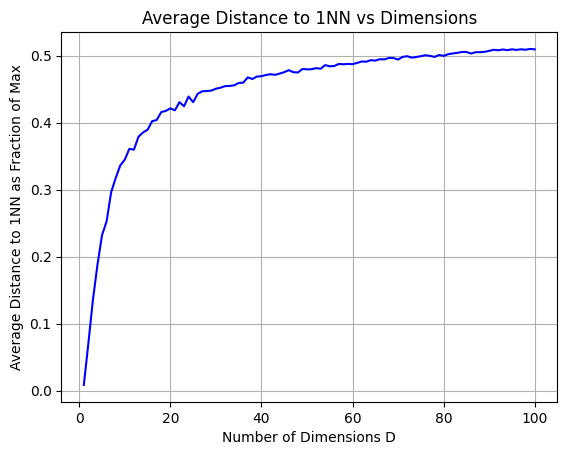

In [9]:
#For a data point at the origin, what is the expected distance to its NN as a function of D?
#Points are sampled in [-1,1]^D uniformly.
#Distances expressed as a fraction of the maximum distance sqrt(D)
dists=np.zeros((maxD+1,S));
for d in np.arange(1,maxD+1):  
    target = np.zeros((1,d));
    for s in range(S):  
        x = np.random.uniform(-1,1,(N,d));
        nbrs = NearestNeighbors(n_neighbors=K,metric='euclidean').fit(x)
        distances, indices = nbrs.kneighbors(target)
        dists[d,s] = np.min(distances[0])/ (d**(0.5))
    
mdists = np.mean(dists,axis=1) 
plt.figure(1)
plt.plot(np.arange(1,maxD+1), mdists[1:],'b-');
plt.xlabel('Number of Dimensions D');
plt.ylabel('Average Distance to 1NN as Fraction of Max');
plt.title('Average Distance to 1NN vs Dimensions')
plt.grid('on')  